# Data Visualization for Bike Sharing Demand

This notebook explores and prepare data for training models for the **Bike Sharing Demand** Problem.
This is inspired from the notebook provided by Vivek Srinivasan on Kaggle at [this link](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile)


## Dataset Description

### Overview

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.


### Data fields
* `datetime`: hourly date + timestamp
* `season`: 1 = spring, 2 = summer, 3 = fall, 4 = winter
* `holiday`: whether a day is considered a holiday
* `workingday`: whether the day is neither a weekend nor holiday
* `weather`:
    - **1**: Clear, Few clouds, Partly cloudy
    - **2**: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - **3**: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - **4**: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* `temp`: temperature in Celsius
* `atemp`: "feels like" temperature in Celcius
* `humidity`: relative humidity
* `windspeed`: wind speed
* `casual`: number of non-registered user rentals initiated
* `registered`: number of registered user rentals initiated
* `count`: number of total rentals (Dependent Variable)

In [42]:
import pylab
import calendar
import numpy as np
import pandas as pd
import missingno as msno
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
# pd.options.mode.chained_assignment = None  # default='warn'
sns.set_style("dark")
sns.set(font_scale=1.2) 
%matplotlib inline

**Load data**

In [43]:
train = pd.read_csv('data/train.csv')
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


**Adding several temporal columns**

The `datetime` feature of this dataset contains interesting information including year, month, day of the week and hour, which can be significantly useful for this problem. Therefore, we're going to derive those features from `datetime` and add them into our dataset.

In [44]:
train['date'] = train.datetime.apply(lambda x: x.split()[0])
train['hour'] = train.datetime.apply(lambda x: x.split()[1].split(":")[0])
train['weekday'] = train.date.apply(
    lambda ds: calendar.day_name[datetime.strptime(ds, "%Y-%m-%d").weekday()])
train['month'] = train.date.apply(
    lambda ds: calendar.month_name[datetime.strptime(ds, "%Y-%m-%d").month])
train['season'] = train.season.map({1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"})
train['weather'] = train.weather.map({
    1: "Clear, Few clouds, Partly cloudy",
    2: "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",
    3: "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",
    4: "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"
})

**Coercing to category type**


Currently, the data types of variables such as "season", "weather", "holiday" are still `int` while they should be `category`. We are going to convert the data type of those variables to `category`. But first, let's add some columns for the purpose of visualization

In [45]:
var_list = ["hour", "weekday", "month", "season", "weather", "holiday", "workingday"]
for var in var_list:
    train[var] = train[var].astype("category")

#### Numerical variables

We're going to visualize the distributions of several numerical variables.

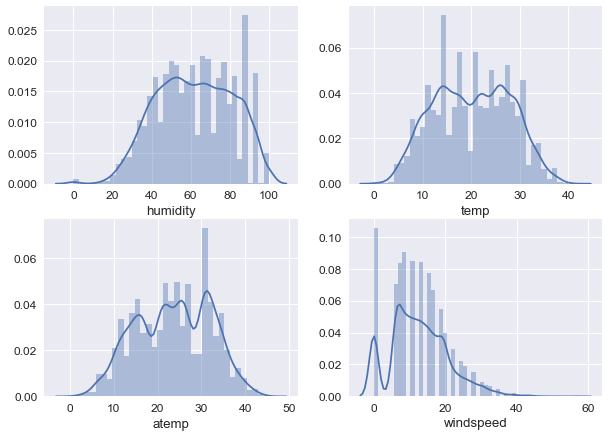

In [46]:
fig = plt.figure(figsize=(10,15))

features = ["humidity", "temp", "atemp", "windspeed"]

for i, feat in enumerate(features):
    plt.subplot(4,2,i+1)
    sns.distplot(train[feat])

plt.show();

### Missing values analysis

In this step, we're going to find if we have any missing values in our data.

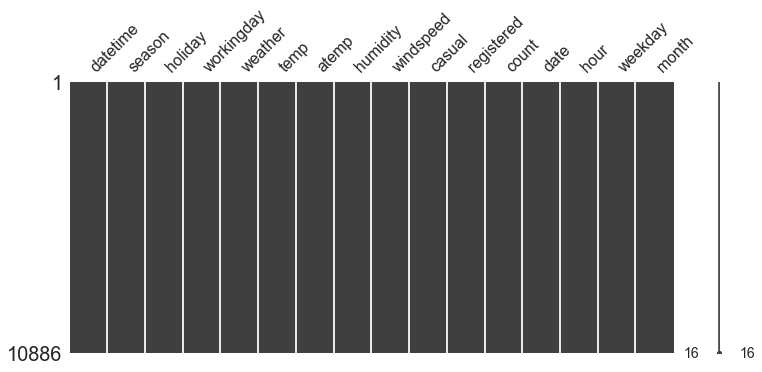

In [47]:
msno.matrix(train, figsize=(12,5))

### Outliers Analysis

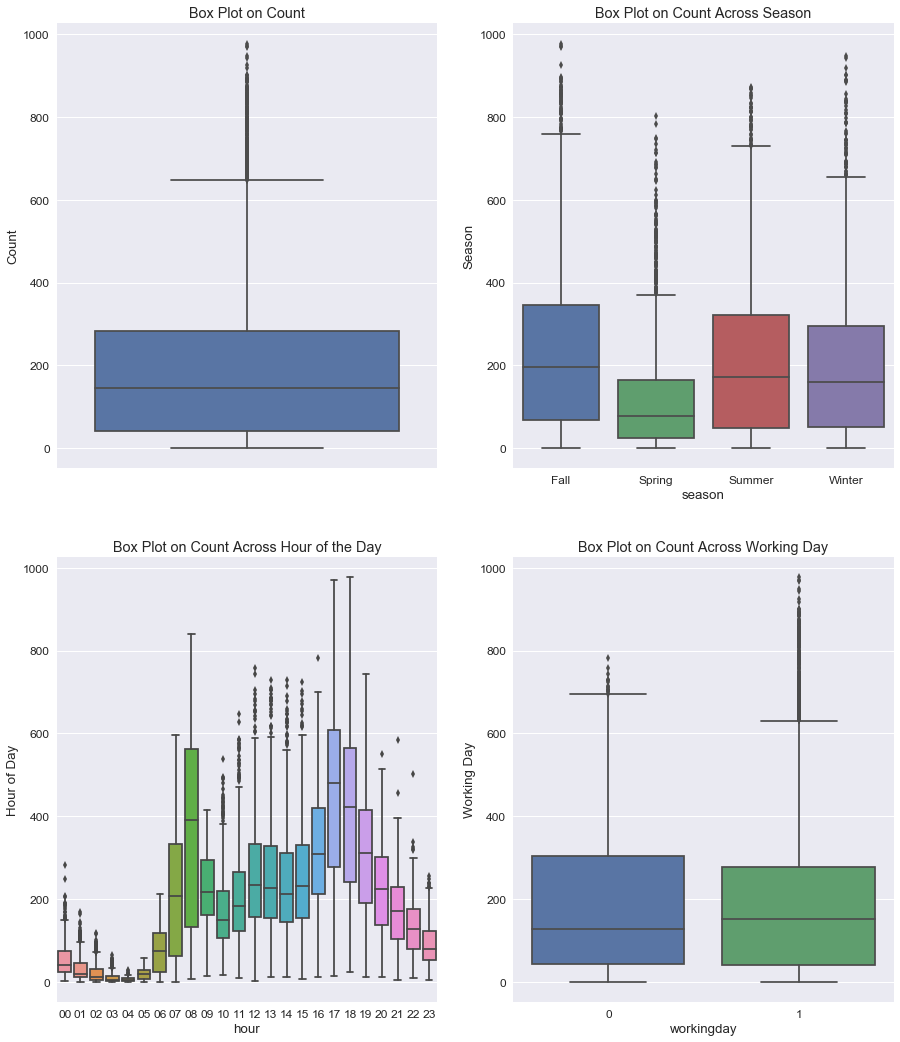

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 18)
sns.boxplot(data=train, y="count", orient="v", ax=axes[0][0])
sns.boxplot(data=train, y="count", x="season", orient="v", ax=axes[0][1])
sns.boxplot(data=train, y="count", x="hour", orient="v", ax=axes[1][0])
sns.boxplot(data=train, y="count", x="workingday", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel='Count', title='Box Plot on Count')
axes[0][1].set(ylabel='Season', title='Box Plot on Count Across Season')
axes[1][0].set(ylabel='Hour of Day', title='Box Plot on Count Across Hour of the Day')
axes[1][1].set(ylabel='Working Day', title='Box Plot on Count Across Working Day')

plt.show();

From the above visualization, we can draw some conclusions as follow:
* Spring has got relatively low counts compared with other seasons.
* From the plot: "Count Across Hour of the Day", we can see that the busy hours include `7AM - 8AM` and `5PM - 6PM`.
* Most of the outlier points are minaly contributed from `Working Day` than `Non Working Day`

**Remove outliers in Count**

In [55]:
trainClean = train[np.abs(train['count'] - train['count'].mean()) <= (3 * train['count'].std())]

### Correlation Analysis

One common to understand how a dependent variable is influenced by features (numerical) is to find a correlation matrix between them.

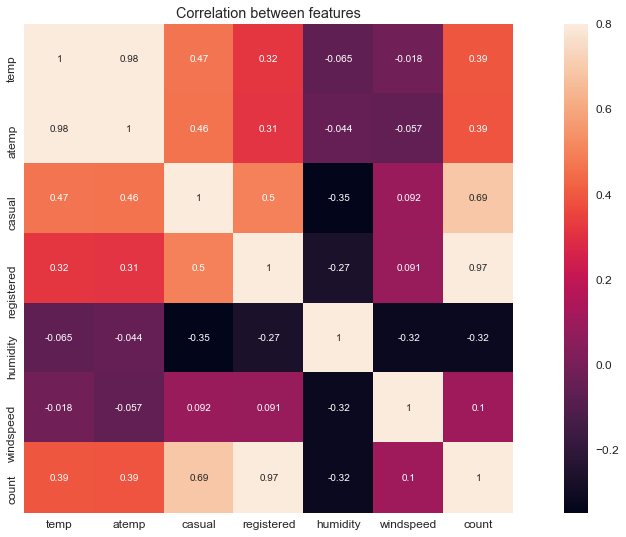

In [53]:
# Calculate correlation matrix of features
corrMatrix = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr()

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
sns.heatmap(corrMatrix, vmax=.8, square=True, annot=True, ax=ax)
ax.set(title='Correlation between features');

From the above plot, we can see that:
* The humidity level (`humidity`) has a negative correlation to the `count`. This can be explained by the fact that people might not want to bike on highly humid days.
* `Windspeed` would not be an useful feature as it shows a positively low correlation with `count`.
* `temp` and `atemp` have strong correlation to each other, though they don't have a strong effect on `count`

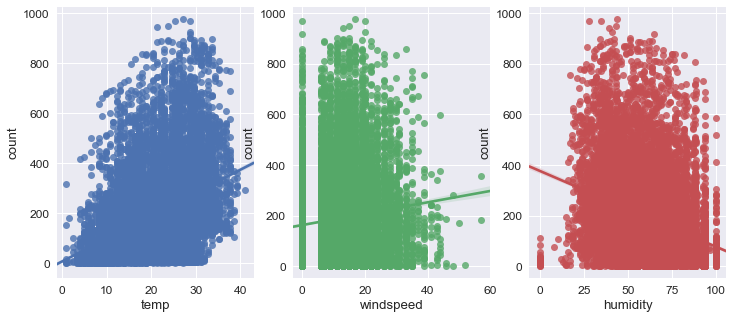

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train, ax=ax1)
sns.regplot(x="windspeed", y="count", data=train, ax=ax2)
sns.regplot(x="humidity", y="count", data=train, ax=ax3);

### Visualizing the Distribution of Data

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229776, 4.5624238680878078, 0.95811767809096171))

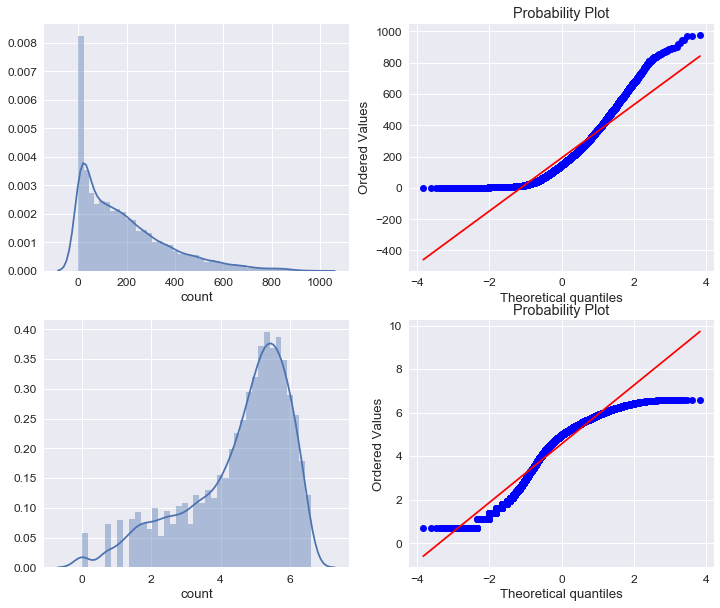

In [56]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(12, 10)

sns.distplot(train['count'], ax=axes[0][0])
stats.probplot(train['count'], dist='norm', fit=True, plot=axes[0][1])

sns.distplot(np.log(trainClean['count']), ax=axes[1][0])
stats.probplot(np.log1p(trainClean['count']), dist='norm', fit=True, plot=axes[1][1])

As it is visible from the above figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

### Visualizing Count vs (Month, Season, Hour, WeekDay, UserType)

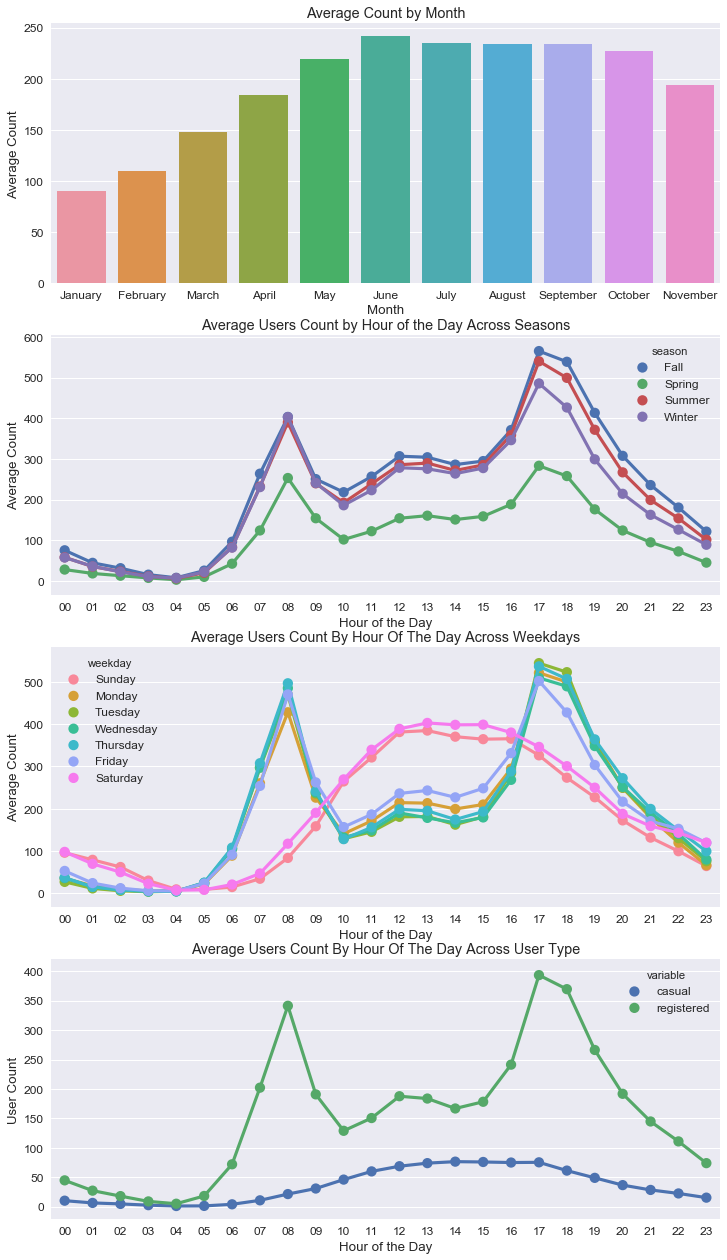

In [60]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,22)

sortOrder = calendar.month_name[1:12]
hueOrder =["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Average Count By Month
monthAggregated = pd.DataFrame(train.groupby('month')['count'].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by='count', ascending=False)
sns.barplot(data=monthSorted, x='month', y='count', ax=ax1, order=sortOrder)
ax1.set(xlabel='Month', ylabel='Average Count', title='Average Count by Month', label='big')

# Average Users Count By Hour of the Day Across Seasons
hourAggregated = pd.DataFrame(train.groupby(['hour', 'season'], sort=True)['count'].mean()).reset_index()
sns.pointplot(data=hourAggregated, hue=hourAggregated['season'],
              x=hourAggregated['hour'], y=hourAggregated['count'], join=True, ax=ax2)
ax2.set(xlabel='Hour of the Day', ylabel='Average Count', label='big',
        title='Average Users Count by Hour of the Day Across Seasons')
        
# Average Users Count By Hour Of The Day Across Weekdays
hourAggregated = pd.DataFrame(train.groupby(['hour', 'weekday'], sort=True)['count'].mean()).reset_index()
sns.pointplot(data=hourAggregated, hue=hourAggregated['weekday'], hue_order=hueOrder,
              x=hourAggregated['hour'], y=hourAggregated['count'], join=True, ax=ax3)
ax3.set(xlabel='Hour of the Day', ylabel='Average Count', label='big',
        title='Average Users Count By Hour Of The Day Across Weekdays')

# Average Users Count By Hour Of The Day Across User Type
hourTransformed = pd.melt(train[['hour', 'casual', 'registered']], id_vars=['hour'],
                          value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(['hour', 'variable'], sort=True)['value'].mean()).reset_index()
sns.pointplot(data=hourAggregated, hue=hourAggregated['variable'],
              x=hourAggregated['hour'], y=hourAggregated['value'], join=True, ax=ax4)
ax4.set(xlabel='Hour of the Day', ylabel='User Count', label='big',
        title='Average Users Count By Hour Of The Day Across User Type')

plt.show();

### Visualizing Count vs (Day of the Week, Hour)

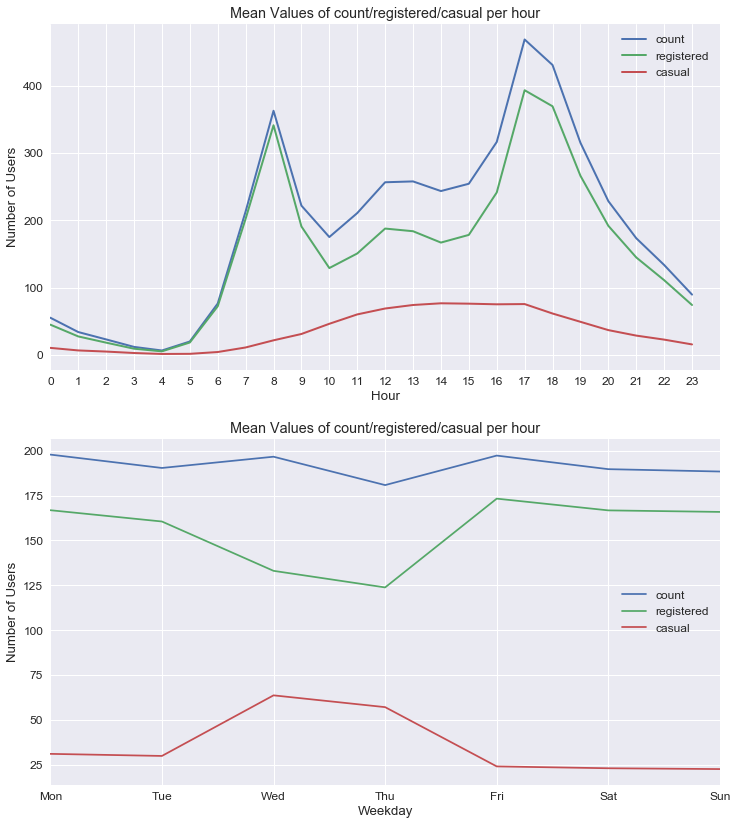

In [92]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 14), nrows=2)
days = [abbr for abbr in calendar.day_abbr]

# Mean value of count/registered/casual per hour
aggr = pd.DataFrame(train.groupby('hour', sort=True)['count', 'registered', 'casual'].mean()).reset_index()
aggr.plot(ax=ax1, linewidth=2)
ax1.set_xlim(0,24)
ax1.set_xticks(range(0,24))
ax1.set(xlabel="Hour", ylabel="Number of Users",
       title="Mean Values of count/registered/casual per hour");

# Mean value of count/registered/casual per weekday
aggr = pd.DataFrame(train.groupby('weekday', sort=True)['count', 'registered', 'casual'].mean()).reset_index()
aggr.plot(ax=ax2)
ax2.set_xlim(0,6)
ax2.set_xticks(range(0,7))
ax2.set_xticklabels(days)
ax2.set(xlabel="Weekday", ylabel="Number of Users",
       title="Mean Values of count/registered/casual per hour");